In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.metrics import Precision, Recall

In [19]:
import os
import shutil
import pandas as pd

def restructuring_data():
    # Load the CSV file with image IDs, angles, and speeds
    data = pd.read_csv('training_norm.csv')

    # Preprocess the data as per your provided logic
    data['angle'] = data['angle']*80 + 50
    data.loc[data['speed'] > 1, 'speed'] = 1

    # Base directory where images are stored
    image_dir = 'training_data/training_data/'

    # Create directories for angle and speed classes
    angle_class_dir = 'angle_class_data'
    speed_class_dir = 'speed_class_data'

    # Get unique classes for angles and speeds
    unique_angles = data['angle'].unique()
    unique_speeds = data['speed'].unique()

    # Make directories for angle classes
    for angle in unique_angles:
        angle_dir = os.path.join(angle_class_dir, str(angle))
        os.makedirs(angle_dir, exist_ok=True)

    # Make directories for speed classes
    for speed in unique_speeds:
        speed_dir = os.path.join(speed_class_dir, str(speed))
        os.makedirs(speed_dir, exist_ok=True)

    # Function to copy images to the respective class directories
    def copy_images_to_class_dirs(row, image_dir, class_dir, class_label):
        source_path = os.path.join(image_dir, f"{int(row['image_id'])}.png")
        target_path = os.path.join(class_dir, str(row[class_label]), f"{int(row['image_id'])}.png")
        if not os.path.exists(target_path):  # Check if the file has already been copied
            shutil.copy(source_path, target_path)

    # Copy images to angle class directories
    data.apply(lambda row: copy_images_to_class_dirs(row, image_dir, angle_class_dir, "angle"), axis=1)

    # Copy images to speed class directories
    data.apply(lambda row: copy_images_to_class_dirs(row, image_dir, speed_class_dir, "speed"), axis=1)

    print("Data restructuring complete.")

Data restructuring complete.


In [8]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

In [4]:
directory = '../../data/angle_class_data'
train_ds = tf.keras.utils.image_dataset_from_directory(
            directory,
            labels='inferred',
            label_mode='categorical',
            class_names = ['65.0','50.0','75.0','115.0','130.0','85.0','105.0','120.0','95.0','80.0','110.0','125.0','90.0','100.0','60.0','70.0','55.0'],
            color_mode='rgb',
            batch_size=64,
            image_size = (240,240),
            shuffle=True,
            seed=123,
            validation_split=0.2,
            subset="training")

val_ds = tf.keras.utils.image_dataset_from_directory(
            directory,
            labels='inferred',
            label_mode='categorical',
            class_names = ['65.0','50.0','75.0','115.0','130.0','85.0','105.0','120.0','95.0','80.0','110.0','125.0','90.0','100.0','60.0','70.0','55.0'],
            color_mode='rgb',
            batch_size=64,
            image_size = (240,240),
            shuffle=True,
            seed=123,
            validation_split=0.2,
            subset="validation")

Found 13793 files belonging to 17 classes.
Using 11035 files for training.
Found 13793 files belonging to 17 classes.
Using 2758 files for validation.


In [5]:
class_names = train_ds.class_names
print(class_names)

['65.0', '50.0', '75.0', '115.0', '130.0', '85.0', '105.0', '120.0', '95.0', '80.0', '110.0', '125.0', '90.0', '100.0', '60.0', '70.0', '55.0']


In [64]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [65]:
data_augmentation = tf.keras.Sequential([tf.keras.layers.RandomBrightness(0.1),
                                        tf.keras.layers.CenterCrop(224,224),
                                        tf.keras.layers.RandomFlip('horizontal'),
                                        tf.keras.layers.RandomZoom(0.1, fill_mode='reflect'),
                                        tf.keras.layers.RandomRotation(0.05, fill_mode='nearest'),

])

In [66]:
# Define preprocessing and augmentation with Gaussian noise
def get_preprocessing_model():
    preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
    data_augmentation = tf.keras.Sequential([
        tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
        tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
        tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
        GaussianNoise(0.1),  # Add Gaussian noise
    ])
    return tf.keras.Sequential([
        data_augmentation,
        tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset=-1),
        tf.keras.layers.Lambda(preprocess_input)  # Apply MobileNetV2 preprocessing
    ])


In [67]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
                                               
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(17, activation='softmax')

In [68]:
inputs = tf.keras.Input(shape=(240,240,3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)
model.summary()

Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 240, 240, 3)]     0         
                                                                 
 sequential_2 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv_13 (TFOpLa  (None, 224, 224, 3)       0         
 mbda)                                                           
                                                                 
 tf.math.subtract_13 (TFOpL  (None, 224, 224, 3)       0         
 ambda)                                                          
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                          

In [69]:
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.001)

model.compile(optimizer=optimizer,
                loss='categorical_focal_crossentropy',
                metrics=['accuracy', Precision(), Recall()])

In [70]:
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds)

Epoch 1/10


: 

In [19]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

NameError: name 'validation_dataset' is not defined

In [3]:
# Load and preprocess images
def load_and_preprocess_image(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, [224, 224])  # Resize images to match model input
    return img, label

In [8]:
# Prepare data with ImageDataGenerator
def prepare_data(csv_file, img_dir, label_type='angle', batch_size=32):
    df = pd.read_csv(csv_file)
    df['image_path'] = df['image_id'].apply(lambda x: os.path.join(img_dir, f"{x}.png"))
    
    # Split data
    train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)
    
    # Augmentation configuration for training
    train_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    
    # No augmentation for validation, only rescaling
    valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
    
    # Train and validation generators
    train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        directory=None,
        x_col='image_path',
        y_col=label_type,
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='binary' if label_type == 'speed' else 'categorical'
    )
    
    valid_generator = valid_datagen.flow_from_dataframe(
        dataframe=valid_df,
        directory=None,
        x_col='image_path',
        y_col=label_type,
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='binary' if label_type == 'speed' else 'categorical'
    )
    
    return train_generator, valid_generator

In [14]:
def mobile_net_classification_model(preprocessing_model):
    inputs = Input(shape=(224, 224, 3))
    x = preprocessing_model(inputs)  # Apply preprocessing and augmentation
    base_model = tf.keras.applications.MobileNetV2(include_top=False, weights="imagenet", input_shape=(224, 224, 3))  # Start with base model
    base_model.trainable=False
    x = base_model(x, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.3)(x)
    angle_output = Dense(17, activation='softmax', name='angle_output')(x)  # Adjust the number of classes
    model = Model(inputs=inputs, outputs=angle_output)
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model, base_model

In [15]:
csv_file = 'training_norm.csv'
img_dir = 'training_data/training_data'  # Adjust as needed
train_ds, valid_ds = prepare_data(csv_file, img_dir, label_type='angle')
preprocessing_model = get_preprocessing_model()  # Get preprocessing model
model, base_model = mobile_net_classification_model(preprocessing_model)
model.summary()

model_output_dir = 'models/angle'
# clean up log folder for tensorboard
log_dir_root = f'{model_output_dir}/logs'
#!rm -rf $log_dir_root
tensorboard_callback = TensorBoard(log_dir_root, histogram_freq=1)
# Specify the file path where you want to save the model
filepath = f'models/angle/mobilenet_{timestamp}'

# Create the ModelCheckpoint callback
model_checkpoint_callback = ModelCheckpoint(
    filepath,
    monitor='val_loss',     # Monitor validation loss
    verbose=1,              # Log a message each time the callback saves the model
    save_best_only=True,    # Only save the model if 'val_loss' has improved
    save_weights_only=False, # Only save the weights of the model
    mode='min',             # 'min' means the monitored quantity should decrease
    save_freq='epoch'       # Check every epoch
)

history = model.fit(
    image_data_generator(X_train, y_train, batch_size=128),
    steps_per_epoch=len(X_train) // 128,
    epochs=10,
    validation_data = image_data_generator(X_valid, y_valid, batch_size=64),
    validation_steps=len(X_valid) // 64,
    verbose=1,
    shuffle=1,
    callbacks=[model_checkpoint_callback, tensorboard_callback]
)

# Initial training with base model frozen
# history = model.fit(train_ds, epochs=10, validation_data=valid_ds)

# # Unfreeze the base model for fine-tuning
# base_model.trainable = True
# model.compile(optimizer=Adam(learning_rate=0.0001),  # Lower learning rate for fine-tuning
#                 loss='categorical_crossentropy',
#                 metrics=['accuracy'])

# # Fine-tuning the model
# fine_tune_epochs = 10
# total_epochs = 10 + fine_tune_epochs

# history_fine = model.fit(train_ds,
#                             epochs=total_epochs,
#                             initial_epoch=history.epoch[-1],
#                             validation_data=valid_ds)

   image_id   angle  speed                         image_path
0         1  0.4375    0.0  training_data/training_data/1.png
1         2  0.8125    1.0  training_data/training_data/2.png
2         3  0.4375    1.0  training_data/training_data/3.png
3         4  0.6250    1.0  training_data/training_data/4.png
4         5  0.5000    0.0  training_data/training_data/5.png


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_7 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_1  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_1 (Dense)             (None, 1024)              1311744   
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0   

In [1]:
from datetime import datetime
ts = datetime.now().strftime('%Y%m%d')
checkpoint_path = f"models/angle/resnet_best"

In [5]:
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.callbacks import ModelCheckpoint
model_checkpoint_callback = ModelCheckpoint(
checkpoint_path,
monitor='val_loss',
verbose=1,
save_best_only=True,
save_weights_only=False,
mode='min',
save_freq='epoch')

In [2]:
import tensorflow as tf
model = tf.keras.models.load_model(checkpoint_path)

2024-03-24 15:28:59.990730: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-03-24 15:28:59.990757: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-03-24 15:28:59.990769: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-03-24 15:28:59.991113: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-03-24 15:28:59.991422: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [3]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.__operators__.getitem (  (None, 160, 160, 3)       0         
 SlicingOpLambda)                                                
                                                                 
 tf.nn.bias_add (TFOpLambda  (None, 160, 160, 3)       0         
 )                                                               
                                                                 
 resnet50 (Functional)       (None, 5, 5, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0     

In [27]:
# optimizer = RMSprop(learning_rate=0.00001)  # Lower learning rate
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.00001)

model.layers[4].trainable = True
for layer in model.layers[4].layers:
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = False


model.compile(optimizer=optimizer,
              loss='categorical_focal_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 224, 224, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 224, 224, 3)       0         
 da)                                                             
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                             

In [ ]:
history_finetune = model.fit(
                        train_ds,
                        validation_data=val_ds,
                        epochs=total_epochs,
                        initial_epoch=10,  # Start fine-tuning from the epoch we left off
                        callbacks=[model_checkpoint_callback],
                        verbose=1)

In [42]:
directory = 'angle_class_data_1'
train_ds = tf.keras.utils.image_dataset_from_directory(
            directory,
            labels='inferred',
            label_mode='categorical', 
            color_mode='rgb',
            batch_size=64,
            # image_size=(160, 160),
            shuffle=True,
            seed=123,
            validation_split=0.2,
            subset="training",
)

Found 13793 files belonging to 17 classes.
Using 11035 files for training.


In [43]:
train_ds.class_names

# total_batches = train_ds.cardinality().numpy()
# total_batches

['100.0',
 '105.0',
 '110.0',
 '115.0',
 '120.0',
 '125.0',
 '130.0',
 '50.0',
 '55.0',
 '60.0',
 '65.0',
 '70.0',
 '75.0',
 '80.0',
 '85.0',
 '90.0',
 '95.0']

In [44]:
label_counts = {}

# Since train_ds does not provide direct access to the label names, you might need to infer them
# This assumes you have equal number of labels as the shape of the second dimension of labels in the first batch
num_labels = next(iter(train_ds))[1].shape[1]  # Get the number of labels from the shape of the labels in the first batch

# Initialize counts for each label to 0
for i in range(num_labels):
    label_counts[i] = 0

# Iterate over each batch in the dataset
for images, labels in train_ds:
    # Sum up the labels for the current batch. This works because labels are one-hot encoded.
    # Convert labels to numpy array for easy processing
    labels_sum = tf.reduce_sum(labels, axis=0).numpy()
    
    # Update counts in the dictionary
    for i in range(num_labels):
        label_counts[i] += labels_sum[i]

# label_counts now contains the count of each category
print("Counts for each category:", label_counts)

# Calculate the total count of images
total_count = sum(label_counts.values())

print("Total count of images:", total_count)

# Obtain the class names from the dataset
category_names = train_ds.class_names

# Create a dictionary mapping from class index to class name
index_to_class_name = {index: class_name for index, class_name in enumerate(category_names)}

print("Index to class name mapping:", index_to_class_name)

# Calculate the total number of samples
total_samples = sum(label_counts.values())

# Number of classes
num_classes = len(label_counts)

# Create a dictionary for class weights with class names as keys
class_weights = {}

y = 0
for index, count in label_counts.items():
    # Calculate the class weight
    weight = total_samples / (num_classes * count)
    
    # Get the class name from the index
    class_name = index_to_class_name[index]
    
    # Assign the weight to the class name key
    class_weights[class_name] = weight

print("Class weights:", class_weights)

Counts for each category: {0: 1569.0, 1: 1605.0, 2: 1695.0, 3: 925.0, 4: 236.0, 5: 56.0, 6: 27.0, 7: 46.0, 8: 25.0, 9: 74.0, 10: 74.0, 11: 80.0, 12: 170.0, 13: 347.0, 14: 1171.0, 15: 1638.0, 16: 1297.0}
Total count of images: 11035.0
Index to class name mapping: {0: '100.0', 1: '105.0', 2: '110.0', 3: '115.0', 4: '120.0', 5: '125.0', 6: '130.0', 7: '50.0', 8: '55.0', 9: '60.0', 10: '65.0', 11: '70.0', 12: '75.0', 13: '80.0', 14: '85.0', 15: '90.0', 16: '95.0'}
Class weights: {'100.0': 0.413714242867319, '105.0': 0.40443467106468756, '110.0': 0.3829602637515183, '115.0': 0.7017488076311605, '120.0': 2.7504985044865404, '125.0': 11.591386554621849, '130.0': 24.04139433551198, '50.0': 14.111253196930946, '55.0': 25.96470588235294, '60.0': 8.771860095389506, '65.0': 8.771860095389506, '70.0': 8.113970588235293, '75.0': 3.8183391003460208, '80.0': 1.870656043397186, '85.0': 0.5543276234490381, '90.0': 0.39628671981613156, '95.0': 0.5004762120731099}


In [40]:
class_weights_indices = {index: weight for index, weight in class_weights.items()}

print("Class weights with indices:", class_weights_indices)

Class weights with indices: {'100.0': 0.6150882051899572, '105.0': 0.6836645921167102, '110.0': 0.6699455702013247, '115.0': 1.2103548367987678, '120.0': 3.732553891121666, '125.0': 16.025098039215685, '130.0': 15.213700670141474, '50.0': 16.92792046396023, '55.0': 14.480510276399716, '60.0': 3.653137850885035, '65.0': 1.2264105642256902, '70.0': 0.6618294895050532, '75.0': 0.6805675837719006, '80.0': 0.6319044968144987, '85.0': 0.4927766924728071, '90.0': 0.7405313326809467, '95.0': 0.49096501345636295}


In [45]:
original_dict = {'100.0': 0.6150882051899572, '105.0': 0.6836645921167102, '110.0': 0.6699455702013247, '115.0': 1.2103548367987678, '120.0': 3.732553891121666, '125.0': 16.025098039215685, '130.0': 15.213700670141474, '50.0': 16.92792046396023, '55.0': 14.480510276399716, '60.0': 3.653137850885035, '65.0': 1.2264105642256902, '70.0': 0.6618294895050532, '75.0': 0.6805675837719006, '80.0': 0.6319044968144987, '85.0': 0.4927766924728071, '90.0': 0.7405313326809467, '95.0': 0.49096501345636295}

# Assuming the order of keys in original_dict matches the desired mapping to 0, 1, 2, ..., 16
transformed_dict = {i: value for i, (_, value) in enumerate(original_dict.items())}

print(transformed_dict)

{0: 0.6150882051899572, 1: 0.6836645921167102, 2: 0.6699455702013247, 3: 1.2103548367987678, 4: 3.732553891121666, 5: 16.025098039215685, 6: 15.213700670141474, 7: 16.92792046396023, 8: 14.480510276399716, 9: 3.653137850885035, 10: 1.2264105642256902, 11: 0.6618294895050532, 12: 0.6805675837719006, 13: 0.6319044968144987, 14: 0.4927766924728071, 15: 0.7405313326809467, 16: 0.49096501345636295}


In [25]:
import tensorflow as tf

def calculate_class_weights_for_binary(dataset):
    # Initialize counts for each label
    label_counts = {0: 0, 1: 0}

    # Iterate over each batch in the dataset
    for images, labels in dataset:
        # Since labels are binary, sum and count can be calculated directly
        labels_sum = tf.reduce_sum(labels).numpy()  # Sum of 1's
        label_counts[1] += labels_sum  # Add sum to count of 1's
        label_counts[0] += labels.shape[0] - labels_sum  # Count of 0's is total minus sum of 1's

    # Calculate the total count of images
    total_count = sum(label_counts.values())

    # Calculate class weights
    class_weights = {}
    for label, count in label_counts.items():
        class_weights[label] = total_count / (2 * count)

    return class_weights

# Example usage for binary classification dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
            'angle_class_data',
            labels='inferred',
            label_mode='categorical', 
            color_mode='grayscale',
            batch_size=64,
            shuffle=True,
            seed=123,
            validation_split=0.2,
            subset="training",
)

# class_weights = calculate_class_weights_for_binary(train_ds)
# print("Class weights for binary classification:", class_weights)

Found 25540 files belonging to 17 classes.
Using 20432 files for training.


In [22]:
def preprocess_image(image, label):
    # Define the list of angles explicitly as a TensorFlow constant for compatibility
    angles = tf.constant([100.0, 105.0, 110.0, 115.0, 120.0, 125.0, 130.0, 50.0, 55.0, 60.0, 65.0, 70.0, 75.0, 80.0, 85.0, 90.0, 95.0], dtype=tf.float32)
    
    # Randomly flip the image
    image = tf.image.random_flip_left_right(image, seed=123)
    
    def adjust_label(label):
        # Find the original angle using the label index
        angle_index = tf.argmax(label, output_type=tf.int32)
        original_angle = tf.gather(angles, angle_index)
        
        # Calculate the mirrored angle
        mirrored_angle = 180 - original_angle
        
        # Find the index of the closest angle in the angles list
        # This compensates for the discrete nature of the angle list
        angle_differences = tf.abs(angles - mirrored_angle)
        new_angle_index = tf.argmin(angle_differences)
        
        # Convert this index back into a one-hot encoded label
        new_label = tf.one_hot(new_angle_index, depth=len(angles))
        return new_label
    
    # Check if the image was flipped by comparing it to a manually flipped version
    flipped_image = tf.image.flip_left_right(image)
    is_flipped = tf.reduce_any(flipped_image != image)
    
    # Adjust the label if the image was flipped
    label = tf.cond(is_flipped, lambda: adjust_label(label), lambda: label)
    
    return tf.cast(image, tf.float32), label

In [23]:
train_ds = train_ds.map(preprocess_image).cache().prefetch(tf.data.AUTOTUNE)

tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.], shape=(17,), dtype=float32)
tf.Tensor(65.0, shape=(), dtype=float32) tf.Tensor(115.0, shape=(), dtype=float32)
tf.Tensor(3, shape=(), dtype=int64)
tf.Tensor([0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], shape=(17,), dtype=float32)
(17,) (17,)
tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.], shape=(17,), dtype=float32)
tf.Tensor(85.0, shape=(), dtype=float32) tf.Tensor(95.0, shape=(), dtype=float32)
tf.Tensor(16, shape=(), dtype=int64)
tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.], shape=(17,), dtype=float32)
(17,) (17,)
tf.Tensor([1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], shape=(17,), dtype=float32)
tf.Tensor(100.0, shape=(), dtype=float32) tf.Tensor(80.0, shape=(), dtype=float32)
tf.Tensor(13, shape=(), dtype=int64)
tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.], shape=(17,), dtype=float32)
(17,) (17,)
tf.Tensor([0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

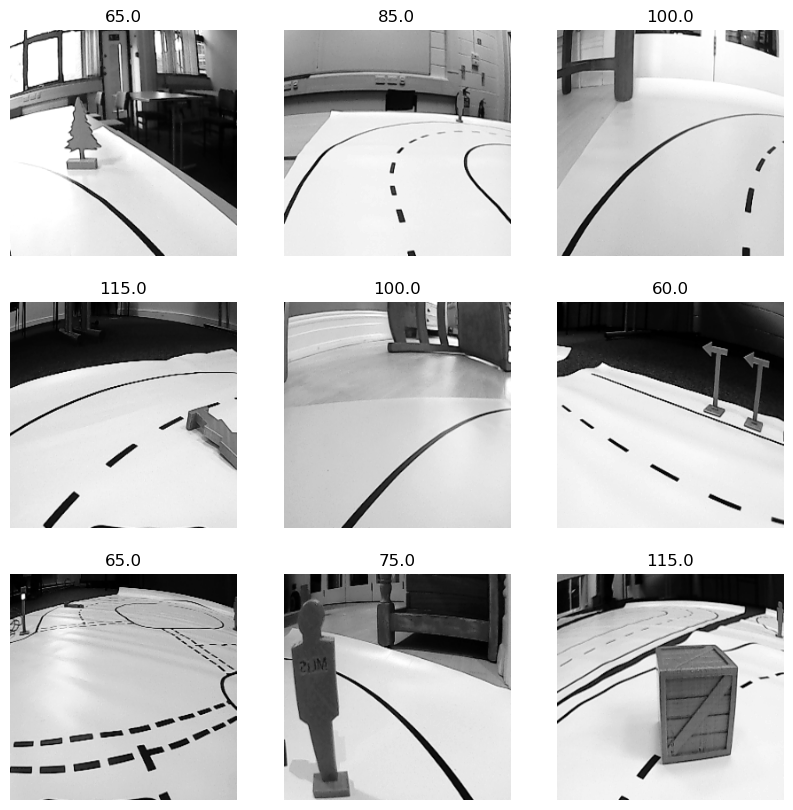

In [41]:
for images, labels in train_ds.take(1): 
    angles = tf.constant([100.0, 105.0, 110.0, 115.0, 120.0, 125.0, 130.0, 50.0, 55.0, 60.0, 65.0, 70.0, 75.0, 80.0, 85.0, 90.0, 95.0], dtype=tf.float32)
    plt.figure(figsize=(10, 10))
    for i in range(9):  # Display the first 9 images from the batch
        print(labels[i])
        angle_index = tf.argmax(labels[i])
        
        original_angle = tf.gather(angles, angle_index)
        print(original_angle, 180 - original_angle)
        new_angle = 180-original_angle
        new_index = tf.where(tf.equal(angles, new_angle))[0][0]
        print(new_index)
        new_label = tf.one_hot(new_index, depth=tf.size(angles))
        print(new_label)
        print(labels[i].shape, new_label.shape)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"), cmap='gray')  # Assuming grayscale images
        plt.title(category_names[tf.argmax(labels[i])])  # Display the label of the image
        plt.axis("off")
    plt.show()
    # print(labels)

['100.0', '105.0', '110.0', '115.0', '120.0', '125.0', '130.0', '50.0', '55.0', '60.0', '65.0', '70.0', '75.0', '80.0', '85.0', '90.0', '95.0']
tf.Tensor(
[[0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]], shape=(64, 17), dtype=float32)


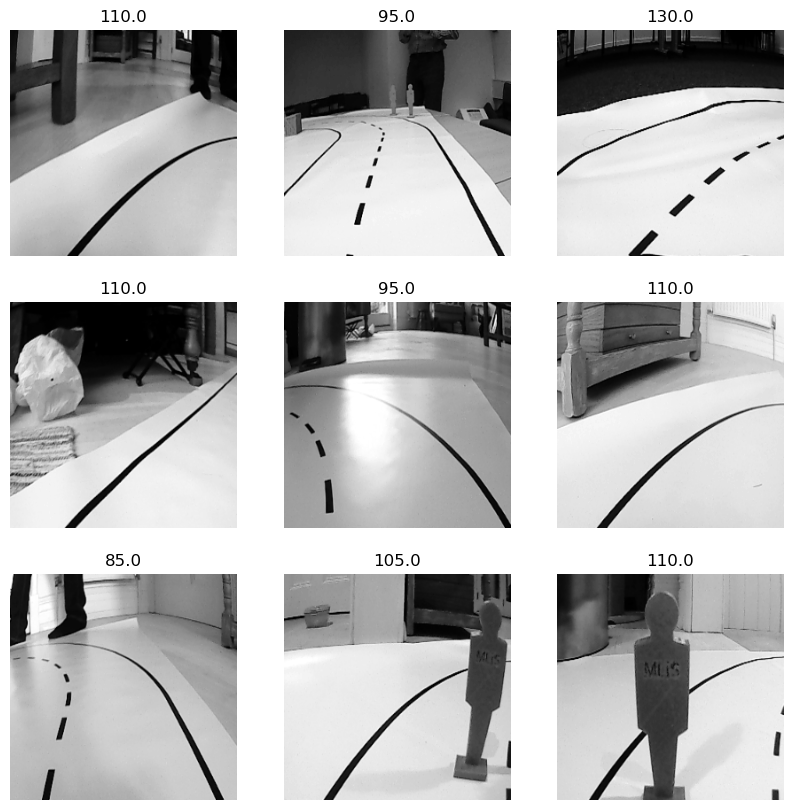

In [10]:
# Obtain the class names for readable label printing
category_names = train_ds.class_names
print(category_names)
# Display a batch of images and labels
for images, labels in train_ds.take(1):  # Only take a single batch
    print(labels)
    plt.figure(figsize=(10, 10))
    for i in range(9):  # Display the first 9 images from the batch
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"), cmap='gray')  # Assuming grayscale images
        plt.title(category_names[tf.argmax(labels[i])])  # Display the label of the image
        plt.axis("off")
    plt.show()
    break  # Since we only want to look at the first batch, break after displaying it

In [29]:
# Calculate the total number of samples
total_samples = sum(label_counts.values())

# Number of classes
num_classes = len(label_counts)

# Create a dictionary for class weights with class names as keys
class_weights = {}

for index, count in label_counts.items():
    # Calculate the class weight
    weight = total_samples / (num_classes * count)
    
    # Get the class name from the index
    class_name = index_to_class_name[index]
    
    # Assign the weight to the class name key
    class_weights[class_name] = weight

print("Class weights:", class_weights)

Class weights: {'100.0': 0.6150882051899572, '105.0': 0.6836645921167102, '110.0': 0.6699455702013247, '115.0': 1.2103548367987678, '120.0': 3.732553891121666, '125.0': 16.025098039215685, '130.0': 15.213700670141474, '50.0': 16.92792046396023, '55.0': 14.480510276399716, '60.0': 3.653137850885035, '65.0': 1.2264105642256902, '70.0': 0.6618294895050532, '75.0': 0.6805675837719006, '80.0': 0.6319044968144987, '85.0': 0.4927766924728071, '90.0': 0.7405313326809467, '95.0': 0.49096501345636295}


In [24]:
# Function to print the shape of images in the dataset
def print_image_shapes(ds, dataset_name):
    for images, labels in ds.take(1):  # Only take 1 batch
        print(f"Image shape for {dataset_name}: {images.shape}")
        # Break after the first batch to just get an example shape

# Print shapes for both datasets
print_image_shapes(train_ds, "Training Dataset")

Image shape for Training Dataset: (64, 256, 256, 3)


(256, 256, 1)
(256, 256, 1)
(256, 256, 1)
(256, 256, 1)
(256, 256, 1)


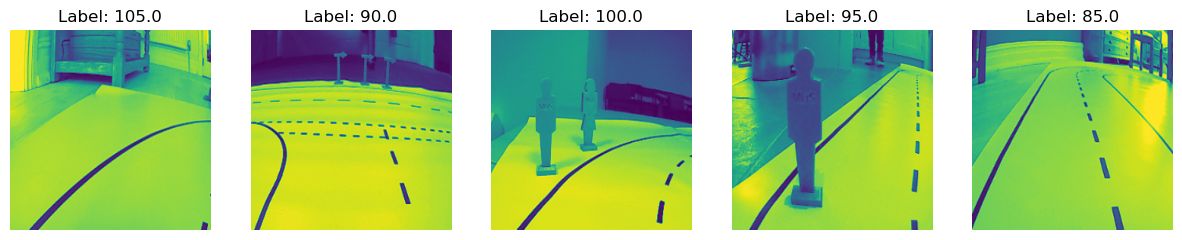

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Take one batch from the dataset
for images, labels in train_ds.take(1):
    plt.figure(figsize=(15, 15))
    # Display the first 5 images from the batch
    for i in range(5):
        ax = plt.subplot(1, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        print(images[i].shape)
        plt.title(f'Label: {train_ds.class_names[np.argmax(labels[i])]}')
        plt.axis("off")
plt.show()

In [89]:
class_names_str = ['100.0', '105.0', '110.0', '115.0', '120.0', '125.0', '130.0', 
                   '50.0', '55.0', '60.0', '65.0', '70.0', '75.0', '80.0', '85.0', 
                   '90.0', '95.0']

# Convert to floats and then sort
class_names_sorted = [float(name) for name in class_names_str]

In [90]:
class_names_sorted

[100.0,
 105.0,
 110.0,
 115.0,
 120.0,
 125.0,
 130.0,
 50.0,
 55.0,
 60.0,
 65.0,
 70.0,
 75.0,
 80.0,
 85.0,
 90.0,
 95.0]

In [52]:
data = pd.read_csv('training_norm.csv')
data['angle'] = data['angle'] * 80 + 50
data.loc[data['speed'] > 1, 'speed'] = 2

In [53]:
data[data['speed']>1]

,image_id,angle,speed
3882,3884,85.0,2.0


In [84]:
directory = 'angle_class_data_1'
train_ds = tf.keras.utils.image_dataset_from_directory(
            directory,
            labels='inferred',
            label_mode='categorical',
            color_mode='rgb',
            batch_size=128,
            image_size = (160,192),
            shuffle=True,
            seed=123,
            validation_split=0.15,
            subset="training")


Found 13793 files belonging to 17 classes.
Using 11725 files for training.


In [87]:
val_ds = tf.keras.utils.image_dataset_from_directory(
            directory,
            labels='inferred',
            label_mode='categorical',
            color_mode='rgb',
            batch_size=64,
            image_size = (160,192),
            shuffle=True,
            seed=123,
            validation_split=0.15,
            subset="validation")

Found 13793 files belonging to 17 classes.
Using 2068 files for validation.


In [88]:
def preprocess_image(image, label):
    # Define the list of angles explicitly as a TensorFlow constant for compatibility
    angles = tf.constant([100.0, 105.0, 110.0, 115.0, 120.0, 125.0, 130.0, 50.0, 55.0, 60.0, 65.0, 70.0, 75.0, 80.0, 85.0, 90.0, 95.0], dtype=tf.float32)
    mirrored_angles = tf.constant([80.0, 75.0, 70.0, 65.0, 60.0, 55.0, 50.0, 130.0, 125.0, 120.0, 115.0, 110.0, 105.0, 100.0, 95.0, 90.0, 85.0], dtype=tf.float32)
    image = tf.image.resize(image, [160, 160]) 
    # Randomly flip the image
    image = tf.image.random_flip_left_right(image, seed=123)

    def adjust_label(label):
        # Convert one-hot encoded label to an index
        label_index = tf.argmax(label, axis=-1)
        
        # Gather the angle value from the angles list using the label index
        angle = tf.gather(angles, label_index)
        
        # Find the index of this angle in the mirrored_angles list
        mirrored_index = tf.where(tf.equal(mirrored_angles, angle))
        
        # Since tf.where might return a 2D tensor, we ensure to flatten it and get the first item
        mirrored_index = tf.reshape(mirrored_index, [-1])[0]
        
        # Create a new one-hot encoded label based on the mirrored index
        new_label = tf.one_hot(mirrored_index, depth=tf.size(angles))
        
        return new_label

    
    # Check if the image was flipped by comparing it to a manually flipped version
    flipped_image = tf.image.flip_left_right(image)
    is_flipped = tf.reduce_any(flipped_image != image)
    
    # Adjust the label if the image was flipped
    label = tf.cond(is_flipped, lambda: adjust_label(label), lambda: label)
    return tf.cast(image, tf.float32), label

In [89]:
train_ds = train_ds.map(preprocess_image).cache().prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.map(preprocess_image).cache().prefetch(tf.data.AUTOTUNE)

In [51]:
class_weights = {0: 0.6150882051899572, 1: 0.6836645921167102, 2: 0.6699455702013247, 3: 1.2103548367987678, 4: 3.732553891121666, 5: 16.025098039215685, 6: 15.213700670141474, 7: 16.92792046396023, 8: 14.480510276399716, 9: 3.653137850885035, 10: 1.2264105642256902, 11: 0.6618294895050532, 12: 0.6805675837719006, 13: 0.6319044968144987, 14: 0.4927766924728071, 15: 0.7405313326809467, 16: 0.49096501345636295}
print("Class weights for multi classification:", class_weights)

Class weights for multi classification: {0: 0.6150882051899572, 1: 0.6836645921167102, 2: 0.6699455702013247, 3: 1.2103548367987678, 4: 3.732553891121666, 5: 16.025098039215685, 6: 15.213700670141474, 7: 16.92792046396023, 8: 14.480510276399716, 9: 3.653137850885035, 10: 1.2264105642256902, 11: 0.6618294895050532, 12: 0.6805675837719006, 13: 0.6319044968144987, 14: 0.4927766924728071, 15: 0.7405313326809467, 16: 0.49096501345636295}


In [90]:
import matplotlib.pyplot as plt
import numpy as np

# Take one batch from the dataset
for images, labels in train_ds.take(1):
    print(labels[i].shape)
    plt.figure(figsize=(15, 15))
    # Display the first 5 images from the batch
    for i in range(5):
        ax = plt.subplot(1, 5, i + 1)
        print(labels[i])
        plt.imshow(images[i].numpy().astype("uint8"))
        # print(images[i].shape)
        plt.title(f'Label: {labels[i]}')
        plt.axis("off")
plt.show()

InvalidArgumentError: {{function_node __wrapped__IteratorGetNext_output_types_2_device_/job:localhost/replica:0/task:0/device:CPU:0}} Incompatible shapes: [17] vs. [128]
	 [[{{function_node cond_true_6040_tfg_region_specialized_cond_0}}{{node cond/Equal_tfg_inlined_cond_0}}]] [Op:IteratorGetNext] name: 

In [91]:
label = 0
angles = tf.constant([100.0, 105.0, 110.0, 115.0, 120.0, 125.0, 130.0, 50.0, 55.0, 60.0, 65.0, 70.0, 75.0, 80.0, 85.0, 90.0, 95.0], dtype=tf.float32)
mirrored_angles = tf.constant([80.0, 75.0, 70.0, 65.0, 60.0, 55.0, 50.0, 130.0, 125.0, 120.0, 115.0, 110.0, 105.0, 100.0, 95.0, 90.0, 85.0], dtype=tf.float32)
angle = tf.gather(angles, label)
new_index = tf.where(tf.equal(mirrored_angles, angle))[0][0]
new_label = tf.cast(new_index, tf.int32)
print(new_label)
# new_index.numpy()
# new_label = tf.constant(new_index.numpy(), shape=(), dtype=tf.int32)
# new_label

tf.Tensor(13, shape=(), dtype=int32)


In [62]:

angle

<tf.Tensor: shape=(), dtype=float32, numpy=100.0>

In [69]:
new_index = tf.where(tf.equal(mirrored_angles, angle))[0][0]
new_index

<tf.Tensor: shape=(), dtype=int64, numpy=13>

In [61]:
new_label = tf.where(tf.equal(mirrored_angles, ))[0][0]

InvalidArgumentError: {{function_node __wrapped__ArgMax_device_/job:localhost/replica:0/task:0/device:CPU:0}} Expected dimension in the range [0, 0), but got 0 [Op:ArgMax] name: 

In [81]:
def adjust_label(label, angles, mirrored_angles):
    # Ensure the label is a one-hot encoded tensor
    label_index = tf.argmax(label, axis=-1)
    angle = tf.gather(angles, label_index)
    mirrored_index = tf.argmax(tf.equal(mirrored_angles, angle), axis=-1)
    new_label = tf.one_hot(mirrored_index, depth=len(angles))
    return new_label

# Define angles and mirrored_angles
angles = tf.constant([100.0, 105.0, 110.0, 115.0, 120.0, 125.0, 130.0, 50.0, 55.0, 60.0, 65.0, 70.0, 75.0, 80.0, 85.0, 90.0, 95.0], dtype=tf.float32)
mirrored_angles = tf.constant([80.0, 75.0, 70.0, 65.0, 60.0, 55.0, 50.0, 130.0, 125.0, 120.0, 115.0, 110.0, 105.0, 100.0, 95.0, 90.0, 85.0], dtype=tf.float32)

# Example label
label_example = tf.one_hot([6], depth=tf.size(angles))
adjusted_label = adjust_label(label_example, angles, mirrored_angles)

print("Adjusted Label:", adjusted_label)

Adjusted Label: tf.Tensor([0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.], shape=(17,), dtype=float32)
